# Multiple Regression (Continued)

6
36
[30.57901916  0.97250508 -1.86503636  0.92319974]
x = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = [-305, -275, -245, -215, -185, -155, -125, -95, -65, -35, -5, 25, 55, 85, 115, 145, 175, 205, 235, 265, 295]
alpha, beta = (-5.0, 3.0)
alpha = 22.947552413468976
beta  = 0.9038659456058724


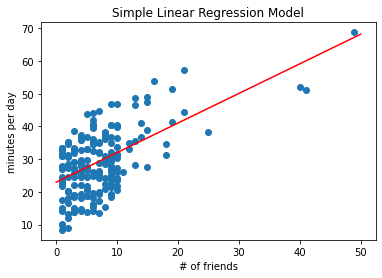

rsq    = 0.3291078377836305
rsq_sk = 0.32910783778362984
r      = 0.57367921156656
r^2    = 0.3291078377836299
22.947552413468976
0.9038659456058724
[22.94755232  0.90386594]
0.6800110181375751
[99.96095009117559, 99.95263765859517, 99.91193675347006, 99.91193675347006, 100.00470211842705, 99.99027449327097, 99.96095009117559, 99.97935713972757, 99.9214102832018, 99.96512568779217, 99.99122691761812, 100.00432599511797, 100.07833662317373, 99.95263765859517, 100.00432599511797, 99.99122691761812, 99.99746144281467, 99.96095009117559, 99.99746144281467, 100.04976976287276, 99.93803411789321, 99.95263765859517, 99.99005515170228, 99.93803411789321, 100.04976976287276, 99.99005515170228, 99.89921066573656, 100.00432599511797, 100.00470211842705, 99.8688480793524, 99.97935713972757, 99.9370472765449, 99.99005515170228, 99.99005515170228, 99.99122691761812, 99.99027449327097, 99.96512568779217, 99.9370472765449, 99.99746144281467, 99.99122691761812, 99.97935713972757, 100.04976976287276, 99

In [2]:
from Week07R import *

## Standard Errors of Regression Coefficients

We can take the same approach to estimating the standard errors of our regression
coefficients. We repeatedly take a `bootstrap_sample` of our data and estimate `beta`
based on that sample.

If the coefficient corresponding to one of the independent variables
(say, `num_friends`) doesn’t vary much across samples, then we can be confident
that our estimate is relatively tight.

If the coefficient varies greatly across samples,
then we can’t be at all confident in our estimate.

The only subtlety is that, before sampling, we’ll need to `zip` our `x` data and `y` data to
make sure that corresponding values of the independent and dependent variables are
sampled together. This means that bootstrap_sample will return a list of pairs `(x_i,
y_i)`, which we’ll need to reassemble into an `x_sample` and a `y_sample`:

In [3]:
from typing import Tuple

def estimate_sample_beta(pairs: List[Tuple[Vector, float]]):
    x_sample = [x for x, _ in pairs]
    y_sample = [y for _, y in pairs]
    beta = least_squares_fit(x_sample, y_sample)
    print("bootstrap sample", beta)
    return beta

random.seed(0) # so that you get the same results when you run this code

# This might take a little while
bootstrap_betas = bootstrap_statistic(list(zip(inputs, daily_minutes_good)),
                                      estimate_sample_beta,
                                      100)

bootstrap sample [29.99254269  1.07613367 -1.91577668  1.186479  ]
bootstrap sample [30.48648594  0.97709026 -2.04192789  2.78209906]
bootstrap sample [29.08889978  0.99449705 -1.66092671  1.80551976]
bootstrap sample [30.92577745  0.96810846 -1.90614804  0.9633214 ]
bootstrap sample [31.9090143   0.96017802 -2.00755542  1.30937309]
bootstrap sample [31.9411427   0.91839887 -1.9199091  -1.2616056 ]
bootstrap sample [ 3.12378020e+01  9.65547464e-01 -1.98724855e+00 -1.72733631e-02]
bootstrap sample [29.85896791  0.98057948 -1.76696754  0.76224239]
bootstrap sample [30.25765875  0.95966604 -1.84749705  0.89937278]
bootstrap sample [31.03285893  0.99048218 -1.93527769  0.04375235]
bootstrap sample [29.64814453  1.19213649 -1.97104106  0.50764887]
bootstrap sample [31.26240567  0.9619901  -1.92961632  0.9808242 ]
bootstrap sample [29.7519696   0.98349785 -1.89373714  2.52523667]
bootstrap sample [31.05247365  0.964177   -2.04809218  0.57252437]
bootstrap sample [31.36499487  0.94962039 -1.9

After which we can estimate the standard deviation of each coefficient:

In [4]:
from statistics import mean

bootstrap_standard_errors = [stdev([beta[i] for beta in bootstrap_betas])
                             for i in range(4)]

bootstrap_param_means = [mean([beta[i] for beta in bootstrap_betas])
                             for i in range(4)]

print(bootstrap_param_means)
print(bootstrap_standard_errors)

[30.55408300846275, 0.9850730066827625, -1.8758456514309334, 0.9532287844812876]
[0.8464395054173437, 0.06587067787018257, 0.10759600504197035, 0.8852940607411107]


```python
# [0.846, # constant term, actual error = 1.19
#  0.066, # num_friends,   actual error = 0.080
#  0.107, # work_hours,    actual error = 0.127
#  0.885] # phd,           actual error = 0.998
```

(We would likely get better estimates if we collected a lot more samples to estimate each `beta`, but we don’t have all day.)

If you have some background in statistics, you could also go ahead and try to perform a hypothesis test to see if each $\beta_i$ parameter equals to 0 or not. For which you may be able to compute a "p-value", which is the probablility value that has the following interpretation: if we assume that the true $\beta_i$ parameter is essentially 0, what is the probability of obtaining an actual $\beta_i$ this extreme from the sample?

Or put it simply, **if the p-value for a parameter lower than some signficance threshold (e.g., 0.05 is a common one), then we assume that parameter is actually significant** in predicting the response variable. Please keep this in mind when you use some regression software and it outputs the p-values for the parameters.

## Regularization

In practice, you’d often like to apply linear regression to datasets with large numbers
of variables. This creates a couple of extra wrinkles.
- First, the more variables you use, the more likely you are to overfit your model to the training set.
- Second, the more nonzero coefficients you have, the harder it is to make sense of them (If the goal is to explain some phenomenon, a sparse model with three factors might be more useful than a slightly better model with hundreds).

*Regularization* is an approach in which we add to the error term a penalty that gets
larger as beta gets larger. We then minimize the combined error and penalty. The
more importance we place on the penalty term, the more we discourage large coefficients.

For example, in *ridge regression*, we add a penalty proportional to the sum of the
squares of the `beta_i` (except that typically we don’t penalize `beta_0`, the constant
term):

In [5]:
# alpha is a *hyperparameter* controlling how harsh the penalty is
# sometimes it's called "lambda" but that already means something in Python
def ridge_penalty(beta: Vector, alpha: float) -> float:
    return alpha * dot(beta[1:], beta[1:])

def squared_error_ridge(x: Vector,
                        y: float,
                        beta: Vector,
                        alpha: float) -> float:
    """estimate error plus ridge penalty on beta"""
    return error(x, y, beta) ** 2 + ridge_penalty(beta, alpha)

def sum_of_sqerrors_ridge(xs: List[Vector], ys: Vector, beta: Vector, alpha) -> float:
    return sum(squared_error_ridge(x_i, y_i, beta, alpha) for x_i, y_i in zip(xs, ys))

We can then plug this into an optimizer in the usual way:

In [6]:
def least_squares_fit_ridge(xs: List[Vector], ys: Vector, alpha: float) -> Vector:
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    def object_fun (beta: Vector):
        return sum_of_sqerrors_ridge (xs, ys, beta, alpha)
    
    # Start with a random guess
    guess = [random.random() for _ in xs[0]]

    optim = minimize (object_fun, guess, method='BFGS')
    
    return optim.x

With `alpha` set to 0, there’s no penalty at all and we get the same results as before:

In [7]:
random.seed(0)
beta_0 = least_squares_fit_ridge(inputs, daily_minutes_good, 0.0)

print(f"beta = {beta_0}")
print(f"sum of squared betas = {dot(beta_0[1:], beta_0[1:])}")
print(f"R^2 = {multiple_r_squared(inputs, daily_minutes_good, beta_0)}")

beta = [30.57901795  0.97250514 -1.86503625  0.92319992]
sum of squared betas = 5.276424566658393
R^2 = 0.6800110181375747


As we increase `alpha`, the goodness of fit gets worse, but the size of `beta` gets smaller:

In [8]:
beta_0_1 = least_squares_fit_ridge(inputs, daily_minutes_good, 0.1)

print(f"beta = {beta_0_1}")
print(f"sum of squared betas = {dot(beta_0_1[1:], beta_0_1[1:])}")
print(f"R^2 = {multiple_r_squared(inputs, daily_minutes_good, beta_0_1)}")

beta = [30.83476977  0.95146517 -1.84689046  0.54706714]
sum of squared betas = 4.615572784013092
R^2 = 0.6797434135107308


In [9]:
beta_1 = least_squares_fit_ridge(inputs, daily_minutes_good, 1)

print(f"beta = {beta_1}")
print(f"sum of squared betas = {dot(beta_1[1:], beta_1[1:])}")
print(f"R^2 = {multiple_r_squared(inputs, daily_minutes_good, beta_1)}")

beta = [30.66730883  0.90642357 -1.69184946  0.09053743]
sum of squared betas = 3.6921553253518407
R^2 = 0.6755909879053199


In [10]:
beta_10 = least_squares_fit_ridge(inputs, daily_minutes_good, 10)

print(f"beta = {beta_10}")
print(f"sum of squared betas = {dot(beta_10[1:], beta_10[1:])}")
print(f"R^2 = {multiple_r_squared(inputs, daily_minutes_good, beta_10)}")

beta = [ 2.83782374e+01  7.28016018e-01 -9.15431147e-01 -1.83800348e-02]
sum of squared betas = 1.3683593325404881
R^2 = 0.5737151109381915


In particular, the coefficient on “PhD” vanishes as we increase the penalty, which
accords with our previous result that it wasn’t significantly different from 0.

Note: usually you’d want to rescale your data before using this
approach. After all, if you changed years of experience to centuries
of experience, its least squares coefficient would increase by a factor
of 100 and suddenly get penalized much more, even though it’s
the same model.

Another approach is *lasso regression*, which uses the penalty:

In [11]:
def lasso_penalty(beta, alpha):
    return alpha * sum(abs(beta_i) for beta_i in beta[1:])

Whereas the ridge penalty shrank the coefficients overall, the lasso penalty tends to
force coefficients to be 0, which makes it good for learning sparse models.

## Linear Regression in scikit-learn

Documentation Link: https://scikit-learn.org/stable/modules/linear_model.html

This example uses the only the first feature of the `diabetes` dataset, in order to illustrate a two-dimensional plot of this regression technique. The straight line can be seen in the plot, showing how linear regression attempts to draw a straight line that will best minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

Intercept: 
 152.91886182616167
Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
R-Squared: 0.47


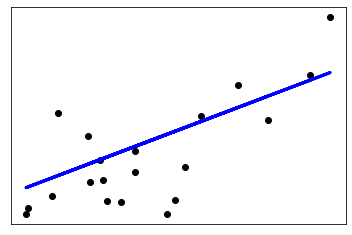

In [12]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature at column 2, for illustrative purposes only so that it's easy to plot the graph later
# Note that in scikit-learn, there's no inherent distinction between Simple Linear Regression and Multiple Linear Regression
# Just pass in the desired X, which contains your features (1 feature: simple linear regression. n features: multiple regression)
# There's no need to include a column of 1's in your X here, it can be controlled by a parameter named "fit_intercept",
# when creating the LinearRegression object later.
diabetes_X = diabetes_X[:, 2:3]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The intercept:
print('Intercept: \n', regr.intercept_)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('R-Squared: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [13]:
y_true = [1, 1.5, 3, 2.7]
y_pred = [0.9, 1.4, 2.9, 3]
print('R-Squared: %.2f'
      % r2_score(y_true, y_pred))

R-Squared: 0.96


And here's a super simple example to fit ridge regression:

In [14]:
reg = linear_model.Ridge(alpha=.5)
reg.fit([[0, 0], [0.2, 1], [1, 1]], [0, .1, 1])
print(reg.intercept_)
print(reg.coef_)

0.07275541795665635
[0.49226006 0.14551084]


And here's lasso regression:

In [9]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit([[0, 0], [0.2, 1], [1, 1]], [0, .1, 1])
print(reg.intercept_)
print(reg.coef_)

0.1666666666666667
[0.5 0. ]


which can be compared with simple linear regression:

In [10]:
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [0.2, 1], [1, 1]], [0, .1, 1])
print(reg.intercept_)
print(reg.coef_)

2.220446049250313e-16
[ 1.125 -0.125]


You can also do polynomial regressions (e.g., quadratic regression, cubic regression, with or without any interaction terms) by expanding the design matrix x with new columns representing the polynomial powers or products of the original columns and then pass the new X to a linear regression object.

In [11]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

X = np.arange(20).reshape(10, 2)
print(X)

y = [(x_i[0] + x_i[1] + np.random.randn()) ** 2  for x_i in X]

poly = PolynomialFeatures(2, include_bias = False) # the initial columns of 1's not needed for LinearRegression()
X2 = poly.fit_transform(X)

print(X2)

reg = linear_model.LinearRegression()
reg.fit(X, y)
print(f"intercept = {reg.intercept_}")
print(f"coefficients = {reg.coef_}")
print(f"Linear Regression R-Squared = {r2_score(y, reg.predict(X))}")

reg.fit(X2, y)
print(f"intercept = {reg.intercept_}")
print(f"coefficients = {reg.coef_}")
print(f"Quadratic Regression R-Squared = {r2_score(y, reg.predict(X2))}")

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
[[  0.   1.   0.   0.   1.]
 [  2.   3.   4.   6.   9.]
 [  4.   5.  16.  20.  25.]
 [  6.   7.  36.  42.  49.]
 [  8.   9.  64.  72.  81.]
 [ 10.  11. 100. 110. 121.]
 [ 12.  13. 144. 156. 169.]
 [ 14.  15. 196. 210. 225.]
 [ 16.  17. 256. 272. 289.]
 [ 18.  19. 324. 342. 361.]]
intercept = -239.81975637033054
coefficients = [38.34184337 38.34184337]
Linear Regression R-Squared = 0.9126048017061228
intercept = 16.969375715729825
coefficients = [-2.16578462 -2.16578462  3.66309735  1.49731272 -0.6684719 ]
Quadratic Regression R-Squared = 0.9927697073095132


## Linear Regression in statsmodels

In [12]:
import statsmodels.api as sm

spector_data = sm.datasets.spector.load()

# unlike scikit-learn, you are required to add a column of 1's if you want to fit the intercept
spector_data.exog1 = sm.add_constant(spector_data.exog) 

print(spector_data.endog) # endogeneous/response/dependent/y variable
print(spector_data.exog1)  # exogenous/explanatory/independent/x variable

# Fit and summarize Ordinary Least Squares (OLS) model
# Be sure to pass in y first, followed by X!
mod = sm.OLS(spector_data.endog, spector_data.exog1)
res = mod.fit()
print(res.summary())

[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 1.]
[[ 1.    2.66 20.    0.  ]
 [ 1.    2.89 22.    0.  ]
 [ 1.    3.28 24.    0.  ]
 [ 1.    2.92 12.    0.  ]
 [ 1.    4.   21.    0.  ]
 [ 1.    2.86 17.    0.  ]
 [ 1.    2.76 17.    0.  ]
 [ 1.    2.87 21.    0.  ]
 [ 1.    3.03 25.    0.  ]
 [ 1.    3.92 29.    0.  ]
 [ 1.    2.63 20.    0.  ]
 [ 1.    3.32 23.    0.  ]
 [ 1.    3.57 23.    0.  ]
 [ 1.    3.26 25.    0.  ]
 [ 1.    3.53 26.    0.  ]
 [ 1.    2.74 19.    0.  ]
 [ 1.    2.75 25.    0.  ]
 [ 1.    2.83 19.    0.  ]
 [ 1.    3.12 23.    1.  ]
 [ 1.    3.16 25.    1.  ]
 [ 1.    2.06 22.    1.  ]
 [ 1.    3.62 28.    1.  ]
 [ 1.    2.89 14.    1.  ]
 [ 1.    3.51 26.    1.  ]
 [ 1.    3.54 24.    1.  ]
 [ 1.    2.83 27.    1.  ]
 [ 1.    3.39 17.    1.  ]
 [ 1.    2.67 24.    1.  ]
 [ 1.    3.65 21.    1.  ]
 [ 1.    4.   23.    1.  ]
 [ 1.    3.1  21.    1.  ]
 [ 1.    2.39 19.    1.  ]]
                            OLS Regr

In [13]:
# Quadratic Regression
# We will just borrow PolynomialFeatures from scikit-learn to generate the appropriate columns for polynomial regression
poly = PolynomialFeatures(2, include_bias = True)
spector_data.exog2 = poly.fit_transform (spector_data.exog)

print(spector_data.exog2)

mod2 = sm.OLS(spector_data.endog, spector_data.exog2)
res2 = mod2.fit()
print(res2.summary())

[[  1.       2.66    20.       0.       7.0756  53.2      0.     400.
    0.       0.    ]
 [  1.       2.89    22.       0.       8.3521  63.58     0.     484.
    0.       0.    ]
 [  1.       3.28    24.       0.      10.7584  78.72     0.     576.
    0.       0.    ]
 [  1.       2.92    12.       0.       8.5264  35.04     0.     144.
    0.       0.    ]
 [  1.       4.      21.       0.      16.      84.       0.     441.
    0.       0.    ]
 [  1.       2.86    17.       0.       8.1796  48.62     0.     289.
    0.       0.    ]
 [  1.       2.76    17.       0.       7.6176  46.92     0.     289.
    0.       0.    ]
 [  1.       2.87    21.       0.       8.2369  60.27     0.     441.
    0.       0.    ]
 [  1.       3.03    25.       0.       9.1809  75.75     0.     625.
    0.       0.    ]
 [  1.       3.92    29.       0.      15.3664 113.68     0.     841.
    0.       0.    ]
 [  1.       2.63    20.       0.       6.9169  52.6      0.     400.
    0.       0.    ]

In [14]:
# Ridge Regression, call fit_regularized instead of fit, set L1_wt = 0
res_ridge = mod.fit_regularized(alpha = 0.05, L1_wt = 0)
print(res_ridge.params)

[-0.35026798  0.2020077  -0.00237391  0.30608729]


In [15]:
# Lasso Regression, call fit_regularized instead of fit, set L1_wt = 1
res_lasso = mod.fit_regularized(alpha = 0.05, L1_wt = 1) # Lasso
print(res_lasso.params)

[0.         0.04180365 0.00709658 0.16680278]
